# Applications of Classification

In this lab you will perform **two-class classification** using **logistic regression**. A classifier is a machine learning model that seperates the **label** into categories or **classes**. In other words, classification models are **supervised** machine learning modeles which predict a categorical label

In this case, bank customer data is used to determine if a particular person is a good or bad credit risk. Thus, credit risk of the customer is the classes you must predict. In this case, the cost to the bank of issuing a loan to a bad risk customer is five times that of denying a loan to a good customer. This fact will become important when evaluating the performance of the model. 

Logistic regression is a linear model but with a nonlinear response. The response is binary, $\{ 0,1 \}$, or positive and negative. The response is the prediction of the category. 

In this lab you will learn the following: 
-  How to prepare data for classification models using Scikit-learn. 
-  Constructing a classification model using Scikit-learn.
-  Evaluating the performance of the classification model. 
-  Using techniques such as reweighting the labels and changing the decision threshold to change the trade-off between false positive and false negative error rates. 

## Basics of logistic regression

In this section some basic properties of the logistic regression model are presented. 

First, execute the code in the cell below to load the packages required  to run this notebook. 

In [47]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`. You can think of this response as having a Binomial distribution. For linear regression the response is just, well, linear. Logistic regression is a linear regression model with a nonlinear output. The response of the linear model is transformed or 'squashed' to values close to 0 and 1 using a **sigmoidal function**, also known as the **logistic function**. The result of this transformation is a response which is the log likelihood for each of the two classes. 

The sigmodial or logistic function can be expressed as follows:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

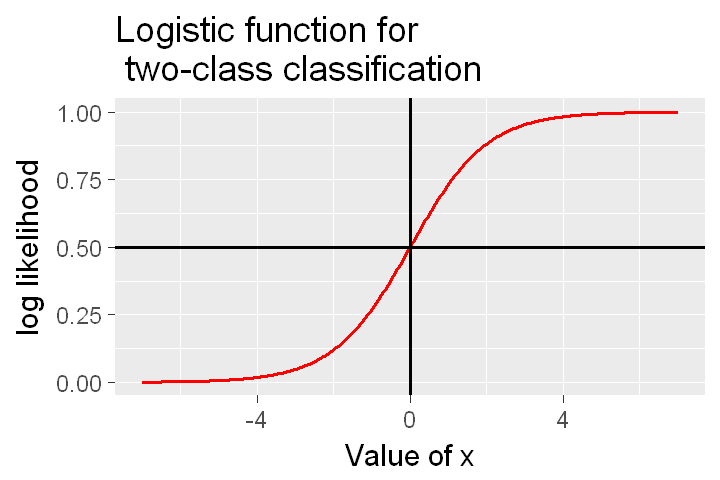

In [48]:
xseq = seq(-7, 7, length.out = 500)
plot.logistic = function(v){
  options(repr.plot.width=6, repr.plot.height=4)
  logistic = exp(xseq - v)/(1 + exp(xseq - v))
  df = data.frame(x = xseq, y = logistic)
  ggplot(df, aes(x,y)) +
    geom_line(size = 1, color = 'red') +
    geom_vline(xintercept = v, size = 1, color = 'black') +
    geom_hline(yintercept = 0.5, size = 1, color = 'black') +
    ylab('log likelihood') + xlab('Value of x') +
    ggtitle('Logistic function for \n two-class classification') +
    theme_grey(base_size = 18)
}
plot.logistic(0)

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. Substituting the linear model into the logistic function creates the following expression:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuious output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$.

## Load and prepare the data set

As a first step, load the dataset. The code in the cell below loads the dataset and displays the head of the data frame. Execute this code and examine the result.

In [49]:
credit = read.csv('German_Credit_Preped.csv')
dim(credit)
head(credit)

[1] 999  23

X,Customer_ID,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1
5,3115687,none,36,current loans paid,education,9055,unknown/none,1 - 4 years,2,...,unknown-none,35,none,for free,1,unskilled-resident,2,yes,yes,0
6,8251714,none,24,current loans paid,furniture/equipment,2835,500 - 1000 DM,>= 7 years,3,...,building society savings/life insurance,53,none,own,1,skilled,1,none,yes,0


There are 21 features, the customer ID, plus a label column. These features represent information a bank might have on its customers. 

The categorical features now have meaningful coding. Additionally the label is now coded as a binary variable. 

## Investigate label imbalance

There is one other aspect of this data set which you should be aware of. The label has significant **class imbalance**. Class imbalance means that there are  unequal numbers of cases for the categories of the label. 

To examine the class imbalance in these data, execute the code in the cell below. 

In [50]:
table(credit[,'bad_credit'])


  0   1 
699 300 

Notice that only 30% of the cases have bad credit. This is not suprising, since a bank would typically retain customers with good credit. However, this imbalance will bias the training of any model. 

## Split the data

You must now create randomly sampled training and test data sets. The `createDataPartition` function from the R caret package is used  to create indices for the training data sample. In this case 70% of the data will be used  for training the model. Execute this code and note the dimensions of the resulting data frame. 

In [51]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(credit[,'credit_history'], times = 1, p = 0.7, list = FALSE)
training = credit[partition,] # Create the training sample
dim(training)
test = credit[-partition,] # Create the test sample
dim(test)

[1] 701  23

[1] 298  23

## Scale numeric features



In [52]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'age_yrs')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,loan_duration_mo,loan_amount,payment_pcnt_income,age_yrs
1,2.2080823,0.9731062,-0.88582584,-1.17991811
4,0.2337638,0.5805881,0.01542803,1.56006911
6,0.2337638,-0.1583336,0.01542803,1.56006911
7,1.2209231,1.3351234,-0.88582584,-0.03089121
9,0.7273434,0.7127589,0.91668189,-0.64959800
10,-0.7533954,-0.7175176,0.01542803,-0.91475805


## Construct the logistic regression model

Now, it is time to compute the logistic regression model. The code in the cell below does the following:
1. Define a logistic regression model object using the `LogisticRegression` method from the Scikit-Learn `linear_model` package.
2. Fit the linear model using the numpy arrays of the features and the labels for the training data set.

Execute this code. 

In [53]:
logistic_mod = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                    family = binomial, data = training)

The model has been computed. Notice that the configuration of the model object has been printed. In this case, only default settings are shown, since no arguments were given to create the model object. 

Now, print and examine the model coeffients by executing the code in the cell below. 

In [54]:
summary(logistic_mod)


Call:
glm(formula = bad_credit ~ loan_duration_mo + loan_amount + payment_pcnt_income + 
    age_yrs + checking_account_status + credit_history + purpose + 
    gender_status + time_in_residence + property, family = binomial, 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3729  -0.7412  -0.4147   0.7794   2.4707  

Coefficients:
                                                      Estimate Std. Error
(Intercept)                                            1.28125    0.61855
loan_duration_mo                                       0.33821    0.12728
loan_amount                                            0.19904    0.13491
payment_pcnt_income                                    0.29228    0.10892
age_yrs                                               -0.13990    0.10652
checking_account_status> 200 DM or salary assignment  -1.00954    0.39725
checking_account_status0 - 200 DM                     -0.56056    0.24358
checking_account_statusnone   

First of all, notice that model coefficients look just as they would for an regression model. This is expected as previously explained. Additionally, nearly all the coefficients have the same magnitude indicating this model is likely to be overfit, given the number of features. 

Recall that the logistic regression model outputs probabities for each class. The class with the highest probability is taken as the score (prediction). Execute the code and the cell below to compute and display a sample of these class probabilities for the test feature set. 

In [57]:
test$score = predict(logistic_mod, newdata = test, type = 'response')
test[1:20, c('bad_credit','score')]

,bad_credit,score
2,0,0.05147292
3,0,0.54878663
5,0,0.46213054
8,0,0.06617320
14,0,0.67371676
16,0,0.03742926
18,1,0.49877049
25,0,0.15839947
27,0,0.26585924
30,0,0.33093614


The first column is the probability of a score of $0$ and the second column is the probability of a score of $1$. Notice that for most, but not all cases, the probability of a score of $0$ is higher than $1$. 

## Score and evaluate the classification model

Now that the class probabilities have been computed these values must be transformed into actual class scores. Recall that the log likelihoods for two-class logistic regression are computed by applying the sigmoid or logistic transformation to the output of the linear model. The simple choice is to set the threshold between the two likelihoods at $0.5$. The code in the cell below applies this inital threshold to the probability of a score of $0$ for the test data. A few examples along with the known labels are then displayed. Execute this code and examine the result.

In [58]:
score_model = function(df, threshold){
    df$score = ifelse(df$score > threshold, 1, 0)
    df
}

test = score_model(test, 0.5)
test[1:20, c('bad_credit','score')]

,bad_credit,score
2,0,0
3,0,1
5,0,0
8,0,0
14,0,1
16,0,0
18,1,0
25,0,0
27,0,0
30,0,0


Some of the positive ($1$) predictions agree with the test labels in the second row, but several do not.

Given the results of the test data, how can you quantify the performance of the model? In general, you must **always use multiple metrics to evaluate the performance of any machine leaning model**, including classifiers. 

For classifiers there are a number of metrics commonly used. The **confusion matrix** layes out the correctly and incorrectly classified cases in a tabular format. There are various metrics derived from the values in the confusion matrix. Some of the common cases are briefly reviewed below. 

**Confusion matrix**

As already stated, the confusion matrix lays out correctly and incorrectly classified cases. For the binary (two-class) case the confusion matrix is organized as follows:

| | Scored Positive | Scored Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Acutal Negative**| False Positive | True Negative |   

Here the four elements in the matrix are defined as:    
**True Positive** or **TP** are cases with positive labels which have been correctly classified as positive.     
**True Negative** or **TN** are cases with negative labels which have been correctly classified as negative.  
**False Positive** or **FP** are cases with negative labels which have been incorrectly classified as positive.   
**False Negative** or **FN** are cases with positive labels which have been incorrectly classified as negative.

When creating a confusion matrix it is important to understand and maintain a convention for which differentiating positive and negative label values. The usual convention is to call the $1$ case positive and the $0$ case negative. 

Notice that there is an ambiguity in which case is considered positive and which is considered negative when the confusion matrix is computed. Whenever you examine a confusion matrix it is a good idea to spend a moment and decide which case is which. This step will help you relate the results to the problem at hand. 

**Accuracy**

Accuracy is a simple and often misused metric. In simple terms, accuracy is the fraction of cases correctly classified. For a two-class classifier accuracy is writen as:

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

Accuracy can be quite misleading. For example, say a classifer is used to detect fraudulent accounts and the rate of fraud is less than 1%. A naive model would be to say all accounts are not fraudulent. This model has accuracy exceeding  0.99. This sounds impressive, but is clearly useless. 

**Precsion**

Precision is the fraction of correctly classified label cases out of all cases classified with that label value. We can express precision by the following relationship:

$$Precision = \frac{M_{i,i}}{\sum_j M_{i,j}}$$

In other words, the precision statistic is the number of correctly classified cases for the lable value divided by all the cases in the column. Thus, precision is sensitive to the number of cases correctly classified for a given score value. 

**Recall**  

Recall is the fraction of cases of a label value correctly classified out of all cases that actually have that label value. We can express recall by the following relationship:

$$Recall = \frac{M_{i,i}}{\sum_i M_{i,j}}$$

In other words, the recall statistic is the number of correctly classified cases for the lable value divided by all the cases in the row. Thus, precision is sensitive to the number of cases correctly classified for a given true label value. 

**F1**

The F1 statistic is weighted average of precision and recall. We can express F1 by the following relationship:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

In other words, F1 is a weighted metric for overall model performance. 

**ROC** and **AUC**

The receiver operating characteristic or ROC is a curve that displays the relationship between the true postive rate on the vertical axis and false positve rate on the horizontal axis. The ROC curve shows the tradeoff between true positive rate and false positive rate. An example is illustrated below.   

In principle, you can pick the desired operating point for a classifier on this curve. Towards the left favors low false positive rate at the expense of true positive rate. Towards the right favors high true positive rate at the expense of higher false positive rate.  

<img src="img/ROC_AUC.jpg" alt="Drawing" style="width:600px; height:400px"/>
<center>**ROC curve with values of AUC for balanced two-class problem**</center>

The AUC is the area or integral under the ROC curve. The overall performance of the classifier is measured by the area under the curve or AUC. But, how can you interpret a specific AUC value? The higher the AUC the lower the increase in false postive rate required to achieve a required true positive rate.  For an ideal classifier the AUC is 1.0. A true positive rate is achieved with a 0 false positive rate. This behavior means that AUC is useful for comparing classifiers. The classifier with higher AUC is generally the better one. 

For balanced cases, random guessing gives an AUC or 0.5. A balanced case has equal numbers of positive and negative cases. So Bernoulli sampling (random guessing) with a probability $p$ for the positive case, will produce a ROC curve that runs diagonally from $0.0,0.0$ to $1.0,1.0$. The area under this trianglular region is 0.5. It is often said that a classifier with an AUC of greater than 0.5 is better than random guessing. But, **for unbalanced cases this statement is not in true in general**. 

****
**Note:** The term receive operating characteristic may seem a bit odd in the machine learning context. This term arose in the early days of radar engineering as a metric to measure the tradeoff between radar signal receiver correctly detecting a target, say an aircraft, and producing a positive response from noise, such as fying birds or clouds. A radar receiver would be adjusted to the desired operating point along its ROC curve. 
****

The code in the cell below implements a function that computes and displays the forementioned classifer performance metrics. The code metrics are computed using the `precision_recall_fscore_support` and `accuracy_score` functions from the `metrics` package of Scikit-Learn. The confusion matrix is computed using the `confusion_matrix` function from this same package. Execute this code and examine the results for the logistic regression model. 

In [64]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf <- ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
    
  out <- data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) <- c('TrueNeg', 'TruePos')
  print(out)  
  
  # Compute and rint metrics
  cat('\n')
  cat(paste('accuracy =', as.character((TP + TN)/(TP + TN + FP + FN)), '\n'))      
  cat(paste('precision =', as.character(signif(TP/(TP + FP)), digits = 2)), '\n')     
  cat(paste('recall =', as.character(TP/(TP + FN))))
}
logistic.eval(test)

        Negative Positive
TrueNeg      186       34
TruePos       42       36

accuracy = 0.74496644295302 
precision = 0.514286 
recall = 0.461538461538462

Examine these results:
1. The confusion matrix shows the following characteristics; a) most of the positive cases are correctly classified, 177 vs. 28, however, b) most negative cases are are scored incorrectly, only 40 correct, vs. 55 incorrect.   
2. The overall accuracy is 0.72. However as just observed this is **extremely misleading!**. In fact the negative cases are poorly classified, and it is these bad credit customers the bank cares most about. This is not an unusually case. Accuracy figures should always be regarded with healthy scepticism.
3. The class imbalance is confirmed. Of the 300 test cases 205 are positive and 95 are negative. 
4. The precision, recall and F1 all show that positive cases are classified reasonably well, but the negative cases are not. As already mentioned, it is these negtive cases that are of greatest importance to the bank. 

Finally, the code in the cell below computes and displays the ROC curve and AUC. The `roc_curve` and `auc` functions from the Scikit-Learn `metrics` package are used to commpute these values. Execute this code and examine the result.

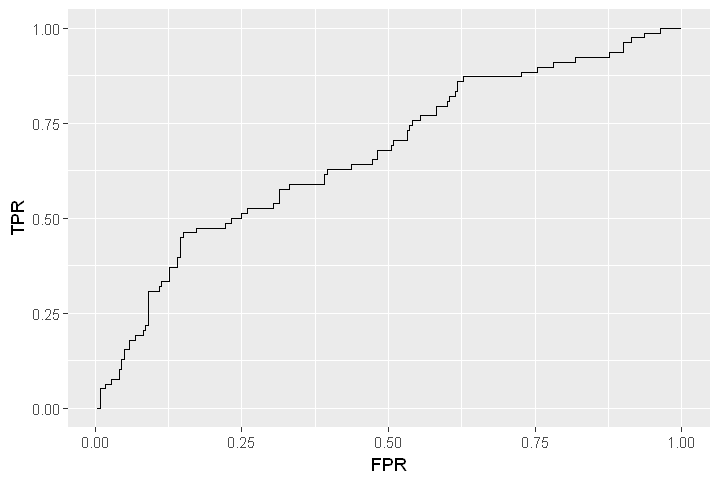

In [84]:
simple_roc <- function(df){
    labels = df$bad_credit
    scores = df$score  
    labels <- labels[order(scores, decreasing=TRUE)]
    out = data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels)
    
    p = ggplot(out, aes(FPR,TPR)) + geom_line()
    print(p)
    out
}

roc = simple_roc(test)

The ROC curve is above the diagonal red-dotted line and the AUC is 0.76. But, given the class imbalance of two positive cases for each negative case how good is this? 

One point of comparison is a naive 'classifier' that sets all cases to positive. The code in the cell below contains such a classifier. This alogrithm is not really a classifier at all. This 'classifier' is hard coded. The ROC curve and AUC are then computed and displayed. Run this code, and examine the result. 

                 Confusion matrix
                 Score positive    Score negative
True positive       205              0
True negative        95              0

Accuracy  0.68
 
             Positive   Negative
Num case    205.00       95.00
Precision   0.68          0.00
Recall      1.00          0.00
F1          0.81          0.00


C:\Users\StevePC2\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


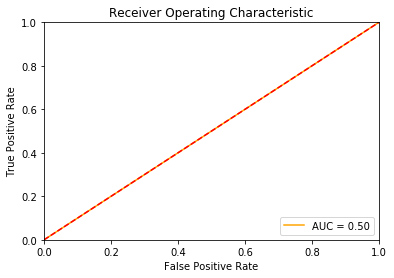

In [16]:
#probs_positive = np.concatenate((np.ones((probabilities.shape[0], 1)), 
#                                 np.zeros((probabilities.shape[0], 1))),
#                                 axis = 1)
#scores_positive = score_model(probs_positive, 0.5)
#print_metrics(y_test, scores_positive)  
#plot_auc(y_test, probs_positive) 

Notice, the accuracy from this 'classifier' is still 0.68. This reflects the class imbalance. The ROC curve is directly along the diagonal which gives an AUC of 0.5. The logistic regression classifier is definitely better than this!

## Compute a weighted model

Recall that a falsely classifing a bad credit risk customer as good costs the bank five times more than classifing a good credit risk customer as bad. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model. As you observed from the accuracy of the naive 'classifier' is not that different from the logistic regression model. 
2. Nothing has been done to weight the results toward correctly classifing the bad credit risk customers at the expense of the good credit risk customers.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below adds a `class_weight` argument to the call to the `LogisticRegression` function. In this case weights are chosen as $0.1, 0.9$ since there is an approximately two to one class imbalance and the asymmetry in the costs of errors to the bank. Execute this code

In [85]:
logistic_mod_w = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                    family = binomial, data = training,
                    weights = c(0.1,0.9))

ERROR: Error in model.frame.default(formula = bad_credit ~ loan_duration_mo + : variable lengths differ (found for '(weights)')


Next, execute the code in the cell below to compute and display the class probabilities for each case. 

In [18]:
probabilities = logistic_mod.predict_proba(x_test)
print(probabilities[:15,:])

[[0.67991032 0.32008968]
 [0.49165574 0.50834426]
 [0.84404653 0.15595347]
 [0.31600472 0.68399528]
 [0.34917118 0.65082882]
 [0.96015149 0.03984851]
 [0.34313761 0.65686239]
 [0.77929504 0.22070496]
 [0.85492161 0.14507839]
 [0.93792393 0.06207607]
 [0.96763624 0.03236376]
 [0.77111192 0.22888808]
 [0.89779186 0.10220814]
 [0.80622461 0.19377539]
 [0.96692379 0.03307621]]


By eyeball, the above probabilities are not terribly different from the unweighted model. 

To find if there is any significant difference with the unweighted model, compute the scores and .the metrics and display the metrics by executing the code in the cell below:

                 Confusion matrix
                 Score positive    Score negative
True positive       174             31
True negative        50             45

Accuracy  0.73
 
             Positive   Negative
Num case    205.00       95.00
Precision   0.78          0.59
Recall      0.85          0.47
F1          0.81          0.53


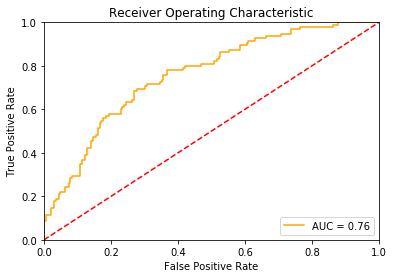

In [19]:
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities)  

The accuracy is essentially unchanged with respect to the unweighted model. The precision, recall and F1 are all slightly worse for the positive cases, but better for the negative cases. Reweighting the labels has moved the results in the desired direction, at least a bit.

Notice also, the ROC curve and AUC are essentially unchanged. The trade-off between true positive and false positive is simiar to the unweighted model. 

## Find a better threshold

There is another way to tip the model scoring toward correctly identifing the bad credit cases. The scoring threshold can be adjusted. Until now, the scores have been computed from the probabilities using a threshold of 0.5. However, there is no reason to think this is the correct choice. Recall that the score is  determined by setting the threshold along the sigmoidal or logistic function. It is possible to favor either positive or negative cases by changing the threshold along this curve. 

The code in the cell below contains a function for scoring and evaluating the model for a given threshold value. The `for` loop iterates over the list of five candidate threshold values. Execute this code and examine how changing the threshold value changes the scoring for the model. 

In [20]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.45
                 Confusion matrix
                 Score positive    Score negative
True positive       166             39
True negative        41             54

Accuracy  0.73
 
             Positive   Negative
Num case    205.00       95.00
Precision   0.80          0.58
Recall      0.81          0.57
F1          0.81          0.57

For threshold = 0.4
                 Confusion matrix
                 Score positive    Score negative
True positive       158             47
True negative        40             55

Accuracy  0.71
 
             Positive   Negative
Num case    205.00       95.00
Precision   0.80          0.54
Recall      0.77          0.58
F1          0.78          0.56

For threshold = 0.35
                 Confusion matrix
                 Score positive    Score negative
True positive       150             55
True negative        31             64

Accuracy  0.71
 
             Positive   Negative
Num case    205.00       95.00
Precision   0.83 

As the threshold is decreased the number of correctly classified negative cases (bad credit customers) increases at the expense of correctly classifing positve cases (good credit customers). At the same time, accuracy decreses. However, as you have observed, accuracy is not a particularly useful metric here. 

Exactly which threshold to pick is a business decision. Notice that with a threshold value of 0.25 the number of false negatives (misclassified good credit customers) is about four times that of false positives (misclassified bad credit customers). 

## Summary

In this lesson you have done the following:
1. Prepared the credit risk data set for modeling with Scikit-Learn. The steps included scaling the numeric features, and dummy variable coding the categorical features. The result is a numpy array of features and a numpy array of the label values. 
2. Computed a logistic regression model. 
3. Evaluated the performance of the module using mutliple metrics. It is clear that accuracy is not a particularly useful metric here. The naive 'classifier' produced accuracy that was only somewhat worse as a result of the class imbalance.  The confusion matrix and the precision, recall and F1 statistics gave meanful mesures of model performance, especially when considered together. 
4. Reweighted the labels and changed the decision threshold for the reweighted model. These steps helped overcome both the class imbalance problem and the asymmetric cost of misclassification to the bank. 